In [1]:
import gc

import torch
import torch.nn.functional as F

from transformers import OPTForCausalLM, GPT2TokenizerFast
from tqdm import trange

from matplotlib import pyplot as plt

from transformers import LogitsProcessorList, LogitsWarper, LogitsProcessor, TopKLogitsWarper, TopPLogitsWarper, TemperatureLogitsWarper, RepetitionPenaltyLogitsProcessor
from warpers import AdvancedRepetitionPenaltyLogitsProcessor, TailFreeLogitsWarper, TypicalLogitsWarper, TopALogitsWarper


/home/arvindanchi/.pyenv/versions/3.10.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-22 11:18:18.288994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 11:18:19.163910: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 11:18:24.545755: W tensorflow/compiler/xla/stream_executor

In [2]:
model_1_path = 'models/OPT-350M-Erebus-50MB'
model_2_path = 'models/OPT-350M-Nerys-v2-100MB'

merged_model_path = 'models/OPT-350M-1Erebus-2Nerys-qkv'

sample_length = 275
prompt = '[Genre:'


In [ ]:
models_probs = {}
model_names = [('model_1', model_1_path), ('model_2', model_2_path)]

for model_name_txt, model_name in model_names:
    model = OPTForCausalLM.from_pretrained(model_name).eval()
    tokenizer = GPT2TokenizerFast.from_pretrained(model_name)

    model.zero_grad(set_to_none=True)
    
    inputs = tokenizer(prompt, return_tensors='pt')

    probs = torch.zeros((sample_length, tokenizer.vocab_size))
    generated_tokens = torch.zeros(sample_length)
    
    with torch.no_grad():
        for input_token_idx in trange(sample_length):
            outputs = model(input_ids=inputs['input_ids'])
            
            token_probs = F.softmax(outputs[0][:, -1, :], dim=-1).squeeze(0)
            sampled_tokens = top_k_top_p_filtering(token_probs * 0.7, top_k=5, top_p=0.85).softmax(-1)
            chosen_token = torch.multinomial(sampled_tokens, num_samples=1)
            
            inputs['input_ids'] = torch.concat((inputs['input_ids'], chosen_token.reshape((1,1))), dim=-1)
            
            probs[input_token_idx] = token_probs
            generated_tokens[input_token_idx] = chosen_token

    print(model_name_txt)
    print(tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
    
    print()

    models_probs[model_name_txt] = (probs, generated_tokens.to(torch.int))
    
    del model
    gc.collect()



In [5]:
model_name_txt, model_name = 'merged_model', merged_model_path

model = OPTForCausalLM.from_pretrained(model_name).eval()
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)

model.zero_grad(set_to_none=True)

prob_list = []

with torch.no_grad():
    for model_base in models_probs.keys():    
        inputs = tokenizer(prompt, return_tensors='pt')
        
        probs = torch.zeros((sample_length, tokenizer.vocab_size))
        generated_tokens = torch.zeros(sample_length)
        
        for input_token_idx in trange(sample_length):
            outputs_merged = model(input_ids=inputs['input_ids'])
            
            token_probs = F.softmax(outputs_merged[0][:, -1, :], dim=-1).squeeze(0)
            next_token = models_probs[model_base][1][input_token_idx].to(torch.int)
            
            inputs['input_ids'] = torch.concat((inputs['input_ids'], next_token.reshape((1,1))), dim=-1)
            
            probs[input_token_idx] = token_probs
            generated_tokens[input_token_idx] = next_token

        prob_list.append(probs)


100%|██████████| 275/275 [03:35<00:00,  1.28it/s]


In [162]:
cos = torch.nn.CosineSimilarity(dim=-1)

prob_list[0] = top_k_top_p_filtering(prob_list[0] * 0.7, top_k=5, top_p=0.85).softmax(-1)
prob_list[1] = top_k_top_p_filtering(prob_list[1] * 0.7, top_k=5, top_p=0.85).softmax(-1)

var_1 = torch.var(cos(models_probs['model_1'][0].softmax(-1), prob_list[0]))
var_2 = torch.var(cos(models_probs['model_2'][0].softmax(-1), prob_list[1]))

var_1_norm, var_2_norm = torch.stack((var_1, var_2)).softmax(-1)

model_1_mix = cos(models_probs['model_1'][0].softmax(-1), prob_list[0]).mean() / var_1_norm
model_2_mix = cos(models_probs['model_2'][0].softmax(-1), prob_list[1]).mean() / var_2_norm

model_1_mix_norm, model_2_mix_norm = torch.stack((model_1_mix, model_2_mix)).softmax(-1)

print(f'"{model_1_path.split("/")[-1]}" : "{model_2_path.split("/")[-1]}"')
print(model_1_mix_norm.item(), ':', model_2_mix_norm.item())


"OPT-350M-Erebus-50MB" : "OPT-350M-Nerys-v2-100MB"
0.5053152441978455 : 0.49468472599983215


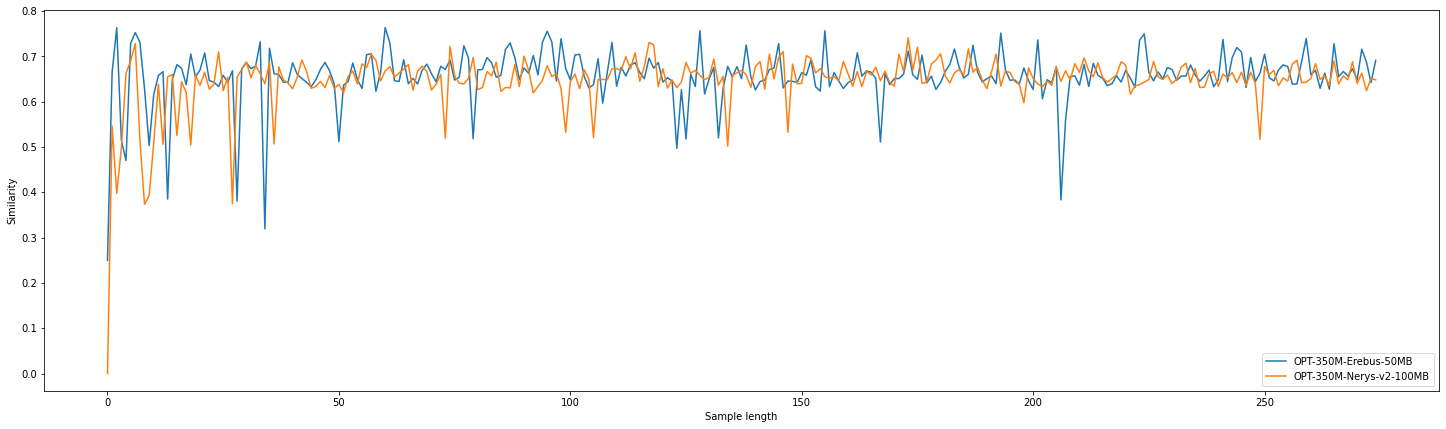

In [173]:
plt.figure(figsize=(25,7))

plt.plot(cos(models_probs['model_1'][0].softmax(-1), prob_list[0]), label=model_1_path.split("/")[-1])
plt.plot(cos(models_probs['model_2'][0].softmax(-1), prob_list[1]), label=model_2_path.split("/")[-1])

plt.xlabel("Sample length")
plt.ylabel("Similarity")

# plt.yscale("log")

plt.legend()

plt.show()
